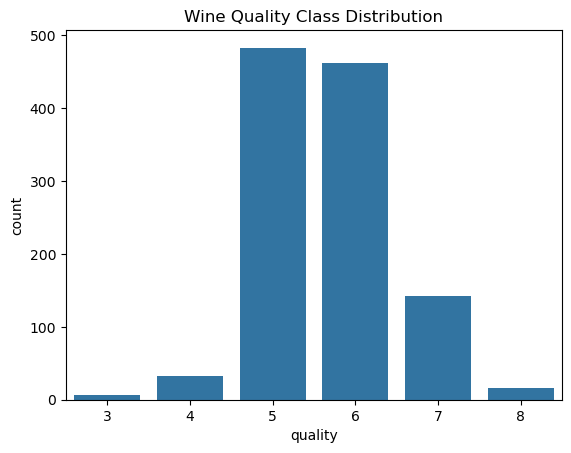

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Random Forest Accuracy: 0.611353711790393
Random Forest Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         6
           5       0.71      0.69      0.70        96
           6       0.64      0.55      0.59        99
           7       0.51      0.77      0.62        26
           8       0.00      0.00      0.00         2

    accuracy                           0.61       229
   macro avg       0.31      0.33      0.32       229
weighted avg       0.63      0.61      0.62       229


SGD Accuracy: 0.40611353711790393
SGD Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
    

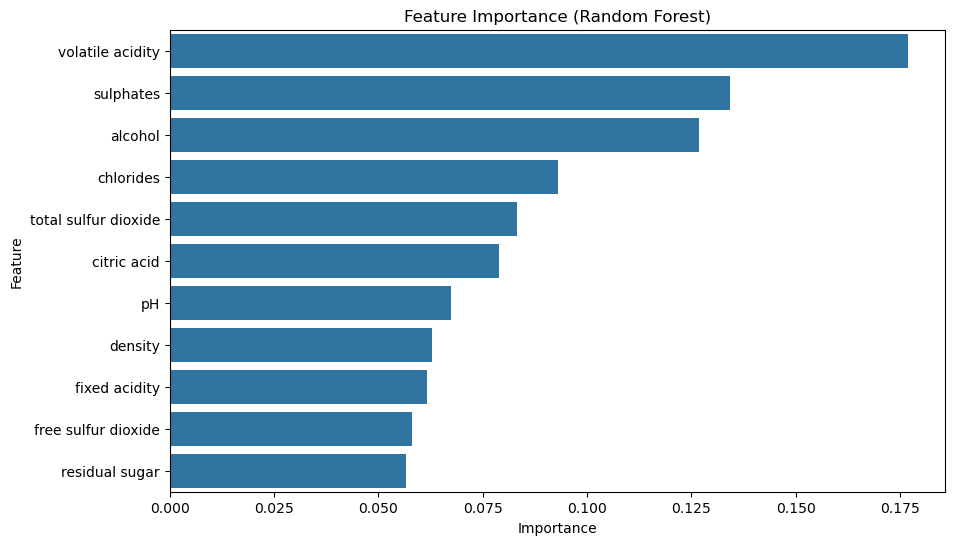

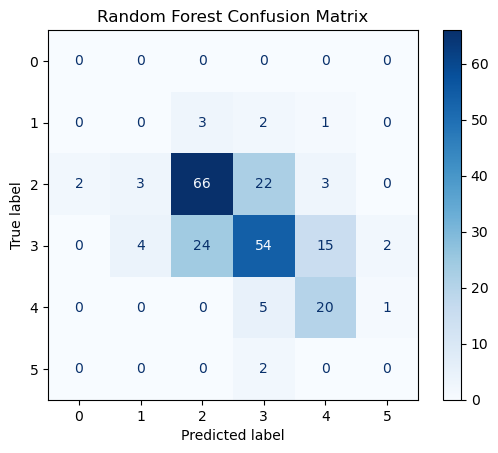

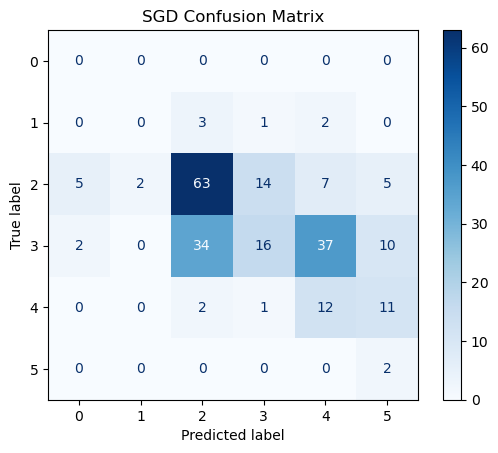

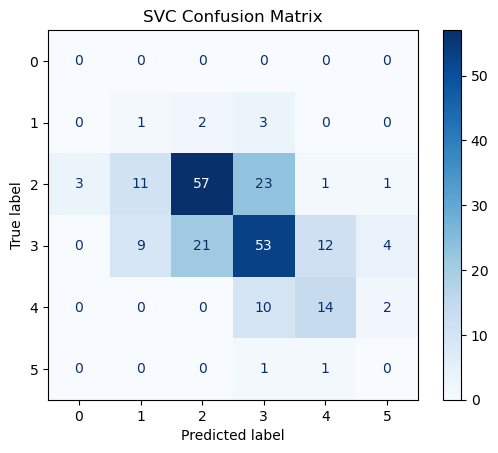

In [1]:

#Idea: Wine Quality Prediction


# Required imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('WineQT.csv')

# Explore the class distribution
sns.countplot(x='quality', data=df)
plt.title('Wine Quality Class Distribution')
plt.show()

# Feature selection and target variable
X = df.drop(columns=['quality', 'Id'])  # Dropping 'Id' and 'quality' (target)
y = df['quality']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Random Forest Classifier ---
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter tuning using RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist_rf, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search_rf.fit(X_resampled, y_resampled)

# Best Random Forest model and evaluation
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

print("Random Forest Best Parameters:", random_search_rf.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# --- Stochastic Gradient Descent (SGD) Classifier ---
sgd_model = SGDClassifier(random_state=42, class_weight='balanced')
sgd_model.fit(X_resampled, y_resampled)

y_pred_sgd = sgd_model.predict(X_test_scaled)
print("\nSGD Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("SGD Classification Report:")
print(classification_report(y_test, y_pred_sgd, zero_division=0))

# --- Support Vector Classifier (SVC) ---
svc_model = SVC(random_state=42, class_weight='balanced')
svc_model.fit(X_resampled, y_resampled)

y_pred_svc = svc_model.predict(X_test_scaled)
print("\nSVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svc, zero_division=0))

# --- Cross-validation for Random Forest ---
rf_cv_scores = cross_val_score(best_rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores:", rf_cv_scores)
print("Random Forest Cross-Validation Mean Accuracy:", rf_cv_scores.mean())

# --- Model Comparison ---
model_scores = {
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'SGD': accuracy_score(y_test, y_pred_sgd),
    'SVC': accuracy_score(y_test, y_pred_svc)
}

print("\nModel Accuracy Comparison:")
for model, score in model_scores.items():
    print(f"{model}: {score:.4f}")

# Feature Importance Visualization for Random Forest
feature_importances = best_rf_model.feature_importances_
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance (Random Forest)')
plt.show()

# Confusion Matrix Visualization for Random Forest
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Confusion Matrix Visualization for SGD
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sgd)).plot(cmap='Blues')
plt.title('SGD Confusion Matrix')
plt.show()

# Confusion Matrix Visualization for SVC
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svc)).plot(cmap='Blues')
plt.title('SVC Confusion Matrix')
plt.show()
